In [213]:
import numpy as np
import pandas as pd 
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import load_img, to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import ReduceLROnPlateau
import os
import random
import zipfile
from sklearn import metrics
import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from google.colab import drive
from google.colab import files

Exploratory Data Analysis and Preprocessing

In [164]:
drive.mount('/content/drive')
!ls "/content/drive/My Drive/Mis apuntes/Nuwe/Zero deforestation mission"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
main.ipynb  test.csv  train.csv  train_test_data  train_test_data.zip


In [165]:
print(os.listdir("../content/drive/My Drive/Mis apuntes/Nuwe/Zero deforestation mission"))

['train.csv', 'test.csv', 'train_test_data.zip', 'main.ipynb', 'train_test_data']


In [166]:
with zipfile.ZipFile("../content/drive/My Drive/Mis apuntes/Nuwe/Zero deforestation mission/train_test_data.zip","r") as z:
    z.extractall(".")

KeyboardInterrupt: ignored

In [ ]:
!unzip "../content/drive/My Drive/Mis apuntes/Nuwe/Zero deforestation mission/train_test_data.zip"

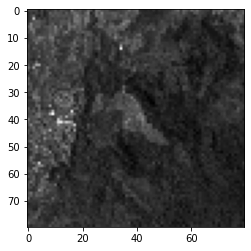

In [167]:
main_dir = "../content/drive/My Drive/Mis apuntes/Nuwe/Zero deforestation mission/train_test_data"
train_dir = "train"
test_dir = "test"
datagen_path = "/content/drive/My Drive/Mis apuntes/Nuwe/Zero deforestation mission/"
path = os.path.join(main_dir, train_dir)

for p in os.listdir(path):
    category = p.split(".")[0]
    img_array = cv2.imread(os.path.join(path,p),cv2.IMREAD_GRAYSCALE)
    new_img_array = cv2.resize(img_array, dsize=(80, 80))
    plt.imshow(new_img_array,cmap="gray")
    break

In [168]:
df = pd.read_csv("/content/drive/My Drive/Mis apuntes/Nuwe/Zero deforestation mission/train.csv")
df.tail()

,label,latitude,longitude,year,example_path
1709,0,3.819464,117.636112,2016,train_test_data/train/550.png
1710,0,-1.809594,111.531951,2005,train_test_data/train/2264.png
1711,1,0.443397,112.200163,2012,train_test_data/train/1486.png
1712,2,-1.978349,101.970148,2012,train_test_data/train/1170.png
1713,2,0.780981,123.368557,2013,train_test_data/train/273.png


In [169]:
test = pd.read_csv("/content/drive/My Drive/Mis apuntes/Nuwe/Zero deforestation mission/test.csv")
test.head()

,latitude,longitude,year,example_path
0,0.761681,122.755954,2006,train_test_data/test/69.png
1,-8.059785,113.053791,2007,train_test_data/test/469.png
2,-2.006610,111.746316,2002,train_test_data/test/6.png
3,0.901765,114.042495,2016,train_test_data/test/351.png
4,1.911210,100.829633,2008,train_test_data/test/1001.png


In [195]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1714 entries, 0 to 1713
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   label         1714 non-null   object 
 1   latitude      1714 non-null   float64
 2   longitude     1714 non-null   float64
 3   year          1714 non-null   int64  
 4   example_path  1714 non-null   object 
dtypes: float64(2), int64(1), object(2)
memory usage: 67.1+ KB


In [196]:
df["label"] = df["label"].astype("str")

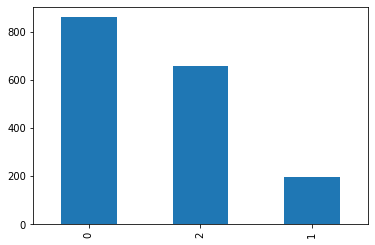

In [197]:
df["label"].value_counts().plot.bar()

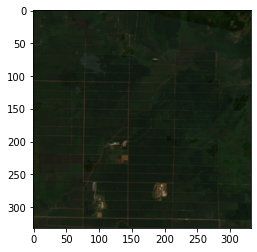

In [198]:
filenames = os.listdir(path)
sample = random.choice(filenames)
image = load_img(path+"/"+sample)
plt.imshow(image)

In [199]:
train_df, validate_df = train_test_split(df, test_size=0.1)
train_df = train_df.reset_index()
validate_df = validate_df.reset_index()
test_df = test

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

In [200]:
image_size = 300
input_shape = (image_size, image_size, 3)
epochs = 30
batch_size = 16
FAST_RUN = False

In [201]:
train_datagen = ImageDataGenerator(
    rotation_range=5,
    rescale=1./255,
    shear_range=0.01,
    zoom_range=0.01,
    horizontal_flip=True,
    # fill_mode="nearest",
    width_shift_range=0.01,
    height_shift_range=0.01
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    datagen_path, 
    x_col="example_path",
    y_col="label",
    class_mode="sparse",
    target_size=(image_size, image_size),
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    datagen_path, 
    x_col="example_path",
    y_col="label",
    class_mode="sparse",
    target_size=(image_size, image_size),
    batch_size=batch_size
)

test_datagen = ImageDataGenerator(rescale = 1./255.)
test_generator = test_datagen.flow_from_dataframe(
        test_df,
        datagen_path, 
        x_col="example_path",
        target_size=(image_size, image_size),
        shuffle=False,
        class_mode=None,
        batch_size=batch_size
)

Found 1542 validated image filenames belonging to 3 classes.
Found 172 validated image filenames belonging to 3 classes.
Found 635 validated image filenames.


Model Building

In [202]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(input_shape)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(3, activation="softmax")) 

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 298, 298, 32)      896       
                                                                 
 batch_normalization_40 (Bat  (None, 298, 298, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 149, 149, 32)     0         
 g2D)                                                            
                                                                 
 dropout_40 (Dropout)        (None, 149, 149, 32)      0         
                                                                 
 conv2d_33 (Conv2D)          (None, 147, 147, 64)      18496     
                                                                 
 batch_normalization_41 (Bat  (None, 147, 147, 64)   

In [203]:
learning_rate_reduction = ReduceLROnPlateau(monitor="val_accuracy", 
                                            patience=10, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [204]:
callbacks = [learning_rate_reduction]

In [205]:
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/30
96/96 [==============================] - 498s 5s/step - loss: 1.5133 - accuracy: 0.4699 - val_loss: 1.0057 - val_accuracy: 0.5375 - lr: 0.0010
Epoch 2/30
96/96 [==============================] - 492s 5s/step - loss: 1.1927 - accuracy: 0.5256 - val_loss: 1.1055 - val_accuracy: 0.3875 - lr: 0.0010
Epoch 3/30
96/96 [==============================] - 485s 5s/step - loss: 1.1303 - accuracy: 0.5315 - val_loss: 1.3510 - val_accuracy: 0.1937 - lr: 0.0010
Epoch 4/30
96/96 [==============================] - 490s 5s/step - loss: 0.9868 - accuracy: 0.5806 - val_loss: 2.0181 - val_accuracy: 0.2438 - lr: 0.0010
Epoch 5/30
96/96 [==============================] - 489s 5s/step - loss: 0.9511 - accuracy: 0.5917 - val_loss: 1.7108 - val_accuracy: 0.2125 - lr: 0.0010
Epoch 6/30
96/96 [==============================] - 483s 5s/step - loss: 0.9018 - accuracy: 0.6245 - val_loss: 2.9556 - val_accuracy: 0.2125 - lr: 0.0010
Epoch 7/30
96/96 [==============================] - 482s 5s/step - loss: 0.8

Plotting the model's results

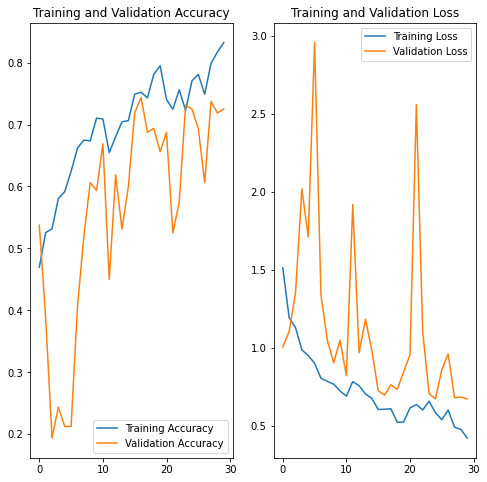

Training Accuracy:
0.8322411775588989
Validation Accuracy:
0.7250000238418579


(None, None)

In [206]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()
 
print("Training Accuracy:"), print(history.history["accuracy"][-1])
print("Validation Accuracy:"), print(history.history["val_accuracy"][-1])

Confusion Matrix

In [211]:
def cm_cr(test_gen, model):
    preds=model.predict(test_gen)    
    labels=test_gen.labels
    classes=list(test_gen.class_indices.keys()) 
    pred_list=[ ] 
    true_list=[]
    for i, p in enumerate(preds):
        index=np.argmax(p)
        pred_list.append(classes[index])
        true_list.append(classes[labels[i]])
    y_pred=np.array(pred_list)
    y_true=np.array(true_list)
    clr = metrics.classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)
    cm = metrics.confusion_matrix(y_true, y_pred )        
    length=len(classes)
    if length<8:
        fig_width=8
        fig_height=8
    else:
        fig_width= int(length * .5)
        fig_height= int(length * .5)
    plt.figure(figsize=(fig_width, fig_height))
    sns.heatmap(cm, annot=True, vmin=0, fmt="g", cmap="Blues", cbar=False)       
    plt.xticks(np.arange(length)+.5, classes, rotation= 90, fontsize=16)
    plt.yticks(np.arange(length)+.5, classes, rotation=0, fontsize=16)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

97/97 [==============================] - 129s 1s/step
Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.47      0.44      0.45       768
           1       0.13      0.15      0.14       179
           2       0.36      0.38      0.37       595

    accuracy                           0.38      1542
   macro avg       0.32      0.32      0.32      1542
weighted avg       0.39      0.38      0.38      1542



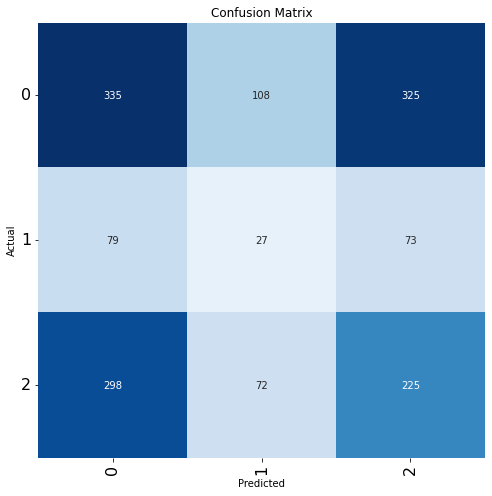

In [218]:
cm_cr(train_generator, model)

11/11 [==============================] - 12s 1s/step
Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.55      0.59      0.57        92
           1       0.14      0.06      0.08        17
           2       0.36      0.38      0.37        63

    accuracy                           0.46       172
   macro avg       0.35      0.34      0.34       172
weighted avg       0.44      0.46      0.45       172



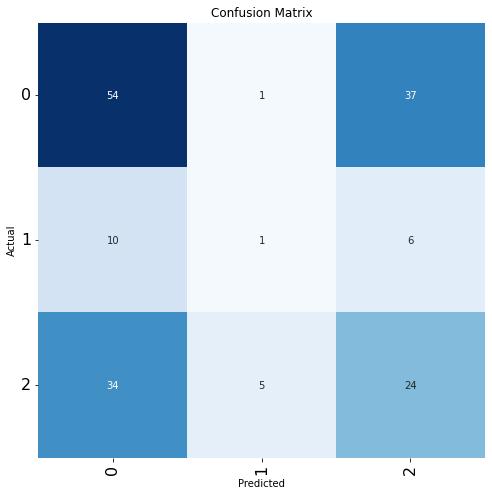

In [216]:
cm_cr(validation_generator, model)

In [217]:
preds = model.predict(test_generator)   
preds

40/40 [==============================] - 141s 4s/step


array([[4.5460171e-01, 4.8289509e-03, 5.4056937e-01],
       [3.2891452e-02, 4.0279132e-01, 5.6431729e-01],
       [2.1838257e-01, 7.8040518e-02, 7.0357698e-01],
       ...,
       [4.0150668e-02, 3.8054147e-01, 5.7930785e-01],
       [9.9971944e-01, 3.0894284e-05, 2.4966078e-04],
       [5.7533455e-01, 1.0288760e-01, 3.2177788e-01]], dtype=float32)

In [219]:
preds = preds.argmax(axis=1)

In [220]:
preds

array([2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 0, 0, 2, 2,
       0, 0, 0, 0, 2, 0, 2, 0, 1, 0, 1, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0,
       2, 0, 2, 0, 0, 0, 0, 1, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       2, 0, 0, 2, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 2,
       2, 0, 1, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 1, 0, 2, 0, 0, 1, 2, 2, 2,
       0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 0,
       0, 1, 0, 2, 2, 0, 0, 2, 2, 2, 0, 0, 2, 0, 1, 0, 0, 0, 0, 2, 2, 2,
       0, 2, 1, 2, 2, 0, 2, 2, 2, 0, 2, 1, 0, 0, 2, 1, 2, 0, 0, 2, 0, 2,
       2, 0, 2, 0, 1, 0, 2, 2, 2, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0,
       0, 2, 1, 1, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0,
       0, 0, 2, 0, 2, 2, 0, 2, 1, 2, 0, 2, 2, 0, 2, 2, 1, 0, 0, 2, 0, 1,
       2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 1, 2, 0, 2, 2, 2, 2, 2,
       0, 2, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1,
       2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 0,

Submission Results

In [249]:
test["target"] = preds.tolist()
# predictions = test["target"].apply(',{}'.format)

In [251]:
test["target"] = test["target"].astype("str")

In [252]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 635 entries, 0 to 634
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   latitude      635 non-null    float64
 1   longitude     635 non-null    float64
 2   year          635 non-null    int64  
 3   example_path  635 non-null    object 
 4   target        635 non-null    object 
dtypes: float64(2), int64(1), object(2)
memory usage: 24.9+ KB


In [237]:
#labels = (train_generator.class_indices)
#labels = dict((v,k) for k,v in labels.items())
#preds_labels = [labels[k] for k in preds]

In [ ]:
#df['Test'] = df['Test'].apply('="{}"'.format)
#df.to_csv('withLeadingZeros'+'.csv', index = False)

In [257]:
#example_path=test_generator.example_path
predictions=pd.DataFrame({"target":preds})
predictions.to_csv("predictions.csv", sep="," ,index = False)
files.download("predictions.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [258]:
predictions_json = pd.read_csv("predictions.csv")
predictions_json.to_json("predictions.json")
files.download("predictions.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>